Projet_Python

# 1)Collect des avis de sécurité ANSSI 

---

## Objectif

Ce notebook a pour objectif de :
- récupérer les **avis de sécurité ANSSI** via le flux RSS,
- explorer leur contenu,
- préparer l’enrichissement avec les bases **MITRE (CVE)** et **EPSS**.

Le notebook sert de **phase exploratoire et de validation** avant intégration dans un script Python final.


##  Présentation du collecteur

Nous utilisons une classe `Collector` qui centralise :
- la récupération du flux RSS ANSSI,
- les appels API externes (MITRE, EPSS),
- la gestion des requêtes HTTP.

Cette approche permet de garder un code **modulaire et réutilisable**.


In [20]:
import feedparser
import requests
from typing import List, Dict, Any, Set


In [21]:

class Collector:
    rss_url = "https://www.cert.ssi.gouv.fr/avis/feed/"
    timeout = 5

    @staticmethod
    def get_rss_entries(url) -> feedparser.util.FeedParserDict:
        print(f"Récupération du flux RSS: {url}")
        rss_feed = feedparser.parse(url)
        print(f"Flux RSS récupéré: {len(rss_feed.entries)} entrées disponibles")
        return rss_feed.entries

    @staticmethod
    def fetch_json(url: str) -> Dict[str, Any]:
        r = requests.get(url, timeout=Collector.timeout)
        r.raise_for_status()
        return r.json()

    @staticmethod
    def fetch_mitre(cve_id: str) -> Dict[str, Any]:
        url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        r = requests.get(url, timeout=Collector.timeout)
        r.raise_for_status()
        return r.json()

    @staticmethod
    def fetch_epss(cve_id: str) -> Dict[str, Any]:
        url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
        r = requests.get(url, timeout=Collector.timeout)
        r.raise_for_status()
        return r.json()

## 2)Enrichissement des CVE (MITRE & EPSS)

Cette section est dédiée à l’enrichissement des identifiants CVE extraits
des avis ANSSI.

L’enrichissement repose sur :
- la base officielle **MITRE (CVE)** pour les descriptions, scores CVSS, CWE et produits affectés ;
- la base **EPSS** pour estimer la probabilité d’exploitation.

L’objectif est d’obtenir une vision **technique et priorisée** des vulnérabilités.


In [22]:
from typing import List, Dict, Any, Set
import feedparser
import requests
import re


In [23]:
class Enrichment:
    """
    Explorer
    --------
    - Extract CVEs from CERT-FR RSS feeds
    - Enrich CVEs with MITRE & EPSS data
    """

    def __init__(
        self,
        enrich_limit: int = 10,
        timeout: int = 10,
    ) -> None:
        self.enrich_limit = enrich_limit
        self.timeout = timeout

    # ---------------------------
    # Enrichment (MITRE / EPSS)
    # ---------------------------
    
    def enrich_cve(self, cve_id: str) -> Dict[str, Any]:
        description: str = "Non disponible"
        cvss_score: str | float = "Non disponible"
        cwe: str = "Non disponible"
        epss_score: str | float = "Non disponible"
        severity: str = "Non disponible"
        products: List[Dict[str, Any]] = []

        # --- MITRE ---
        try:
            print(f" Récupération MITRE pour {cve_id}...")
            mitre = Collector.fetch_mitre(cve_id)
            cna = mitre["containers"]["cna"]

            descs = cna.get("descriptions", [])
            if descs:
                description = descs[0].get("value", description)

            metrics = cna.get("metrics", [])
            if metrics:
                m0 = metrics[0]
                if "cvssV3_1" in m0:
                    cvss_score = m0["cvssV3_1"].get("baseScore", cvss_score)
                    severity = m0["cvssV3_1"].get("baseSeverity", severity)
                elif "cvssV3_0" in m0:
                    cvss_score = m0["cvssV3_0"].get("baseScore", cvss_score)
                    severity = m0["cvssV3_0"].get("baseSeverity", severity)

            problemtype = cna.get("problemTypes", [])
            if problemtype and problemtype[0].get("descriptions"):
                cwe = problemtype[0]["descriptions"][0].get("cweId", cwe)

            # Extraction des produits affectés
            affected = cna.get("affected", [])
            for aff in affected:
                vendor = aff.get("vendor", "N/A")
                product = aff.get("product", "N/A")
                versions = []
                for v in aff.get("versions", []):
                    version_str = v.get("version", "")
                    if version_str:
                        versions.append(version_str)
                products.append({
                    "vendor": vendor,
                    "product": product,
                    "versions": versions
                })
            print(f" MITRE récupéré (CVSS: {cvss_score}, Severity: {severity})")

        except Exception as e:
            print(f"    Erreur MITRE: {e}")

        # --- EPSS ---
        try:
            print(f" Récupération EPSS pour {cve_id}...")
            epss = Collector.fetch_epss(cve_id)
            data = epss.get("data", [])
            if data:
                epss_score = data[0].get("epss", epss_score)
            print(f"    EPSS récupéré: {epss_score}")
        except Exception as e:
            print(f"    Erreur EPSS: {e}")

        return {
            "cve": cve_id,
            "description": description,
            "cvss": cvss_score,
            "severity": severity,
            "cwe": cwe,
            "epss": epss_score,
            "products": products if products else [{"vendor": "N/A", "product": "N/A", "versions": []}],
        }

### Test d’enrichissement d’une CVE

Nous testons l’enrichissement sur une CVE connue afin de valider :
- la récupération MITRE,
- le score EPSS,
- la structure des données retournées.


In [24]:
enricher = Enrichment()

result = enricher.enrich_cve("CVE-2023-34362")
result


 Récupération MITRE pour CVE-2023-34362...
 MITRE récupéré (CVSS: Non disponible, Severity: Non disponible)
 Récupération EPSS pour CVE-2023-34362...
    EPSS récupéré: 0.942540000


{'cve': 'CVE-2023-34362',
 'description': "In Progress MOVEit Transfer before 2021.0.6 (13.0.6), 2021.1.4 (13.1.4), 2022.0.4 (14.0.4), 2022.1.5 (14.1.5), and 2023.0.1 (15.0.1), a SQL injection vulnerability has been found in the MOVEit Transfer web application that could allow an unauthenticated attacker to gain access to MOVEit Transfer's database. Depending on the database engine being used (MySQL, Microsoft SQL Server, or Azure SQL), an attacker may be able to infer information about the structure and contents of the database, and execute SQL statements that alter or delete database elements. NOTE: this is exploited in the wild in May and June 2023; exploitation of unpatched systems can occur via HTTP or HTTPS. All versions (e.g., 2020.0 and 2019x) before the five explicitly mentioned versions are affected, including older unsupported versions.",
 'cvss': 'Non disponible',
 'severity': 'Non disponible',
 'cwe': 'Non disponible',
 'epss': '0.942540000',
 'products': [{'vendor': 'n/a'

### Analyse des résultats

Les données enrichies permettent :
- d’évaluer la **sévérité technique** (CVSS),
- d’identifier la **probabilité d’exploitation** (EPSS),
- de cibler les **produits impactés**.

Ces informations seront utilisées pour :
- prioriser les vulnérabilités,
- produire des exports (CSV / JSON),
- alimenter un tableau de bord.


## 3 )Création du DataFrame
- créer un DataFrame pandas



In [25]:
import pandas as pd
from utils import to_json_url
from collect import Collector
from extract import Extractor
from enrich import Enrichment


In [26]:
def build_dataframe(rss_url, bulletin_type, enrichment: Enrichment, limit=5):
    rows = []
    entries = Collector.get_rss_entries(rss_url)
    print(f"\nNombre total d'entrées RSS récupérées: {len(entries)}")
    print(f"Limite appliquée: {limit} entrées\n")

    for idx, entry in enumerate(entries[:limit], 1):
        print(f"\n{'='*80}")
        print(f"Traitement du bulletin {idx}/{limit}: {entry.title}")
        print(f"{'='*80}")
        
        # Extraire les CVE pour cette entrée spécifique
        json_url = to_json_url(entry.link)
        print(f"URL JSON: {json_url}")
        
        try:
            print(f"Récupération des données JSON...")
            data = Collector.fetch_json(json_url)
            print(f"Données récupérées")
            
            print(f"Extraction des CVE...")
            cves = Extractor.extract_cves_from_bulletin(data)
            print(f"{len(cves)} CVE trouvées: {cves}")
        except Exception as e:
            print(f"Erreur lors de l'extraction pour {entry.title}: {e}")
            continue

        for cve_idx, cve in enumerate(cves, 1):
            print(f"\n Enrichissement CVE {cve_idx}/{len(cves)}: {cve}")
            info = enrichment.enrich_cve(cve)
            print(f" CVE {cve} enrichie (CVSS: {info['cvss']}, EPSS: {info['epss']})")

            products = info["products"] or [{"vendor": "N/A", "product": "N/A", "versions": []}]

            for p in products:
                rows.append({
                    "Titre bulletin (ANSSI)": entry.title,
                    "Type bulletin": bulletin_type,
                    "Date publication": getattr(entry, "published", None),
                    "Identifiant CVE": cve,
                    "Score CVSS": info["cvss"],
                    "Base Severity": info["severity"],
                    "Type CWE": info["cwe"],
                    "Score EPSS": info["epss"],
                    "Lien bulletin (ANSSI)": entry.link,
                    "Description": info["description"],
                    "Éditeur/Vendor": p["vendor"],
                    "Produit": p["product"],
                    "Versions affectées": ", ".join(p["versions"])
                })

    print(f"\n{'='*80}")
    print(f"Traitement terminé! {len(rows)} lignes générées")
    print(f"{'='*80}\n")
    return pd.DataFrame(rows)

## 4)Export CSV
- exporter le résultat en CSV

In [77]:
# Initialisation de l'enrichisseur
enricher = Enrichment()

# Construire DataFrame
df = build_dataframe(
    rss_url=Collector.rss_url,
    bulletin_type="Avis de sécurité",
    enrichment=enricher,
    limit=5  # Ajuster selon besoin
)

# Export CSV
csv_file = "cves_consolides.csv"
df.to_csv(csv_file, index=False)
print(f"CSV '{csv_file}' créé avec {len(df)} lignes")


 Récupération du flux RSS: https://www.cert.ssi.gouv.fr/avis/feed/
 Flux RSS récupéré: 40 entrées disponibles

Nombre total d'entrées RSS récupérées: 40
Limite appliquée: 5 entrées


Traitement du bulletin 1/5: Multiples vulnérabilités dans Trend Micro Apex Central (08 janvier 2026)
URL JSON: https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-AVI-0012/json/
Récupération des données JSON...
Données récupérées
Extraction des CVE...
3 CVE trouvées: ['CVE-2025-69258', 'CVE-2025-69259', 'CVE-2025-69260']

 Enrichissement CVE 1/3: CVE-2025-69258
     Récupération MITRE pour CVE-2025-69258...
     MITRE récupéré (CVSS: 9.8, Severity: CRITICAL)
     Récupération EPSS pour CVE-2025-69258...
     EPSS récupéré: 0.002010000
 CVE CVE-2025-69258 enrichie (CVSS: 9.8, EPSS: 0.002010000)

 Enrichissement CVE 2/3: CVE-2025-69259
     Récupération MITRE pour CVE-2025-69259...
     MITRE récupéré (CVSS: 7.5, Severity: HIGH)
     Récupération EPSS pour CVE-2025-69259...
     EPSS récupéré: 0.001040000
 CVE CVE

# Exploration du DataFrame

Nous allons maintenant explorer le fichier CSV pour :
- vérifier la structure des données,
- détecter les valeurs manquantes,
- préparer les visualisations.


In [78]:
# Chargement CSV
df = pd.read_csv(csv_file)

In [79]:
df.head()

,Titre bulletin (ANSSI),Type bulletin,Date publication,Identifiant CVE,Score CVSS,Base Severity,Type CWE,Score EPSS,Lien bulletin (ANSSI),Description,Éditeur/Vendor,Produit,Versions affectées
0,Multiples vulnérabilités dans Trend Micro Apex...,Avis de sécurité,"Thu, 08 Jan 2026 00:00:00 +0000",CVE-2025-69258,9.8,CRITICAL,CWE-290,0.00201,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,A LoadLibraryEX vulnerability in Trend Micro A...,"Trend Micro, Inc.",Trend Micro Apex Central,2019 (14.0)
1,Multiples vulnérabilités dans Trend Micro Apex...,Avis de sécurité,"Thu, 08 Jan 2026 00:00:00 +0000",CVE-2025-69259,7.5,HIGH,CWE-346,0.00104,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,A message unchecked NULL return value vulnerab...,"Trend Micro, Inc.",Trend Micro Apex Central,2019 (14.0)
2,Multiples vulnérabilités dans Trend Micro Apex...,Avis de sécurité,"Thu, 08 Jan 2026 00:00:00 +0000",CVE-2025-69260,7.5,HIGH,CWE-346,0.00104,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,A message out-of-bounds read vulnerability in ...,"Trend Micro, Inc.",Trend Micro Apex Central,2019 (14.0)
3,Vulnérabilité dans Tenable Nessus Agent (08 ja...,Avis de sécurité,"Thu, 08 Jan 2026 00:00:00 +0000",CVE-2025-36640,Non disponible,Non disponible,CWE-269,0.00012,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,A vulnerability has been identified in the ins...,Tenable,Nessus Agent,"0, 11.0.0"
4,Multiples vulnérabilités dans GitLab (08 janvi...,Avis de sécurité,"Thu, 08 Jan 2026 00:00:00 +0000",CVE-2025-10569,6.5,MEDIUM,CWE-770,0.00039,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,GitLab has remediated an issue in GitLab CE/EE...,GitLab,GitLab,"8.3, 18.6, 18.7"


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Titre bulletin (ANSSI)  21 non-null     object 
 1   Type bulletin           21 non-null     object 
 2   Date publication        21 non-null     object 
 3   Identifiant CVE         21 non-null     object 
 4   Score CVSS              21 non-null     object 
 5   Base Severity           21 non-null     object 
 6   Type CWE                21 non-null     object 
 7   Score EPSS              21 non-null     float64
 8   Lien bulletin (ANSSI)   21 non-null     object 
 9   Description             21 non-null     object 
 10  Éditeur/Vendor          20 non-null     object 
 11  Produit                 20 non-null     object 
 12  Versions affectées      20 non-null     object 
dtypes: float64(1), object(12)
memory usage: 2.3+ KB


In [81]:
df.isnull().sum()

Titre bulletin (ANSSI)    0
Type bulletin             0
Date publication          0
Identifiant CVE           0
Score CVSS                0
Base Severity             0
Type CWE                  0
Score EPSS                0
Lien bulletin (ANSSI)     0
Description               0
Éditeur/Vendor            1
Produit                   1
Versions affectées        1
dtype: int64

# 5)Visualisations et analyses

Nous analysons :
- la distribution CVSS,
- la répartition par sévérité,
- les produits / éditeurs les plus touchés,
- relation CVSS vs EPSS,
- évolution temporelle des bulletins.


In [82]:
# -----------------------
# Imports
# -----------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
# -----------------------
# Chargement des données
# -----------------------
CSV_FILE = "cves_consolides.csv"
df = pd.read_csv(CSV_FILE)

print("Nombre total de lignes :", len(df))
print("Colonnes :", list(df.columns))

# Nettoyage minimal
df["Score CVSS"] = pd.to_numeric(df["Score CVSS"], errors="coerce")
df["Score EPSS"] = pd.to_numeric(df["Score EPSS"], errors="coerce")

Nombre total de lignes : 21
Colonnes : ['Titre bulletin (ANSSI)', 'Type bulletin', 'Date publication', 'Identifiant CVE', 'Score CVSS', 'Base Severity', 'Type CWE', 'Score EPSS', 'Lien bulletin (ANSSI)', 'Description', 'Éditeur/Vendor', 'Produit', 'Versions affectées']


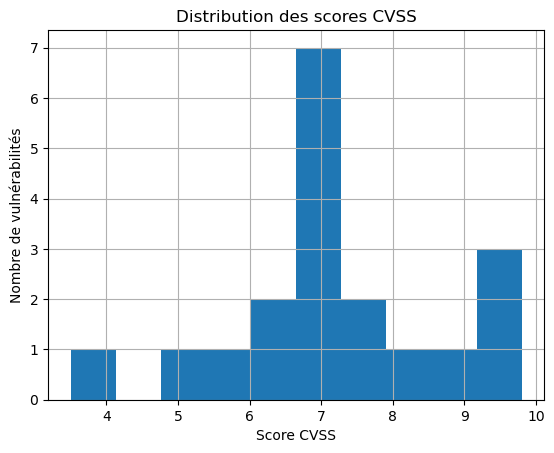

In [96]:
# -----------------------
# 1) Histogramme CVSS
# -----------------------

plt.figure()
df["Score CVSS"].dropna().hist(bins=10)
plt.title("Distribution des scores CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.show()

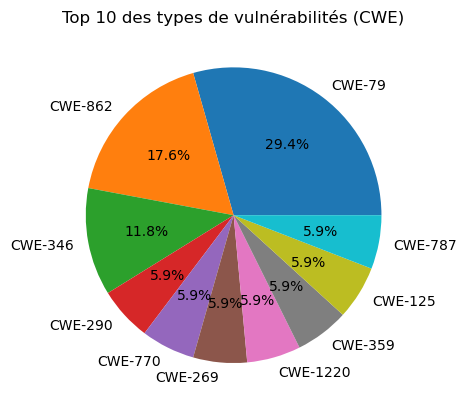

In [97]:
# -----------------------
# 2) Diagramme circulaire des CWE
# -----------------------

plt.figure()
df["Type CWE"].value_counts().head(10).plot.pie(autopct="%1.1f%%")
plt.title("Top 10 des types de vulnérabilités (CWE)")
plt.ylabel("")
plt.show()

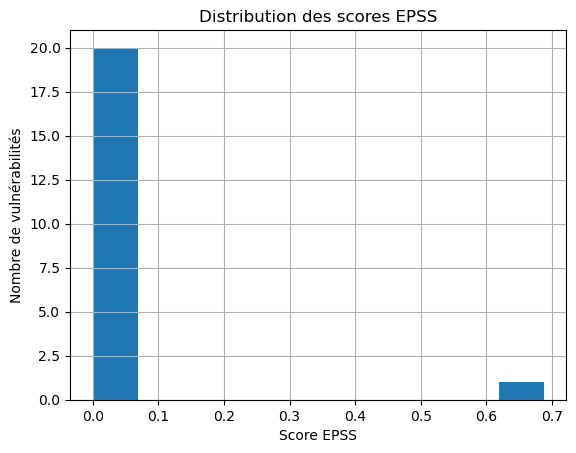

In [98]:
# -----------------------
# 3) Distribution EPSS
# -----------------------

plt.figure()
df["Score EPSS"].dropna().hist(bins=10)
plt.title("Distribution des scores EPSS")
plt.xlabel("Score EPSS")
plt.ylabel("Nombre de vulnérabilités")
plt.show()

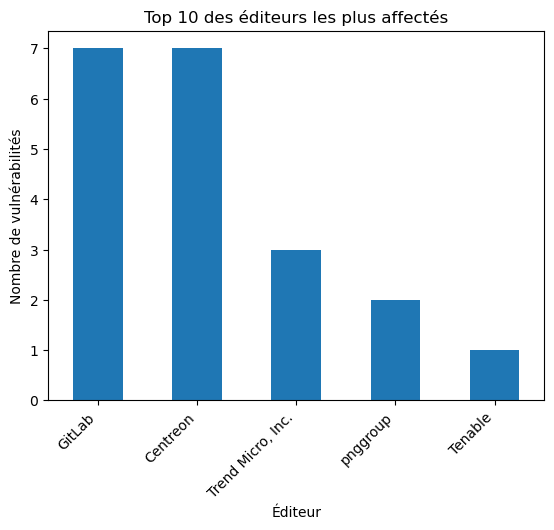

In [99]:

# -----------------------
# 4) Top éditeurs les plus affectés
# -----------------------

top_vendors = df["Éditeur/Vendor"].value_counts().head(10)

plt.figure()
top_vendors.plot.bar()
plt.title("Top 10 des éditeurs les plus affectés")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45, ha="right")
plt.show()

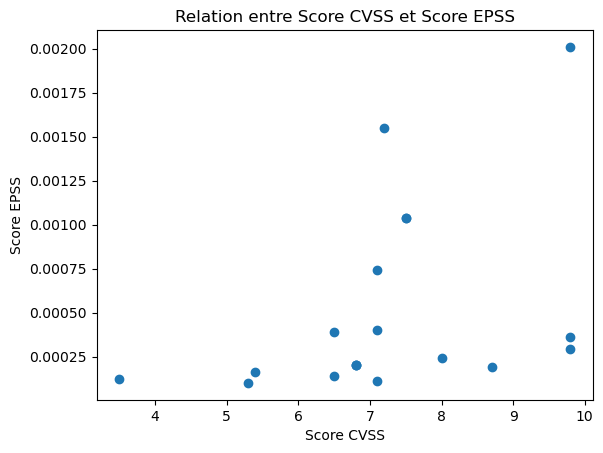

In [100]:

# -----------------------
# 5) Nuage de points CVSS vs EPSS
# -----------------------

plt.figure()
plt.scatter(df["Score CVSS"], df["Score EPSS"])
plt.title("Relation entre Score CVSS et Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.show()

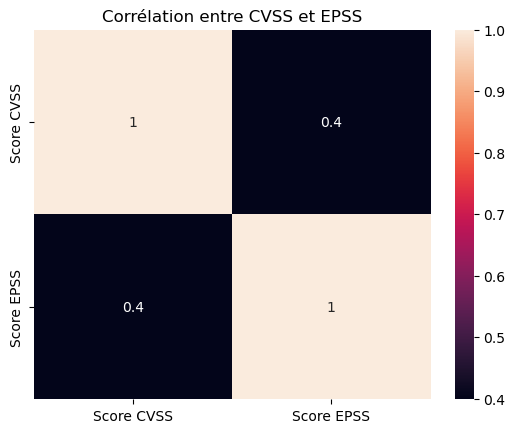

In [105]:
# -----------------------
# 6) Heatmap corrélation CVSS / EPSS
# -----------------------
plt.figure()
corr = df[["Score CVSS", "Score EPSS"]].corr()
sns.heatmap(corr, annot=True)
plt.title("Corrélation entre CVSS et EPSS")
plt.show()

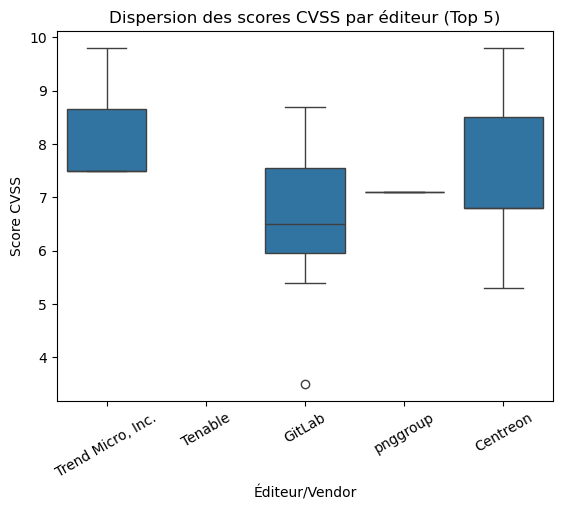

In [106]:
# -----------------------
# 7) Boxplot CVSS par éditeur (top 5)
# -----------------------

top5_vendors = df["Éditeur/Vendor"].value_counts().head(5).index
df_top5 = df[df["Éditeur/Vendor"].isin(top5_vendors)]

plt.figure()
sns.boxplot(x="Éditeur/Vendor", y="Score CVSS", data=df_top5)
plt.title("Dispersion des scores CVSS par éditeur (Top 5)")
plt.xticks(rotation=30)
plt.show()

In [104]:

# -----------------------
# 8) Vulnérabilités critiques (CVSS ≥ 9)
# -----------------------
critical = df[df["Score CVSS"] >= 9]

print("\nNombre de vulnérabilités CRITIQUES (CVSS ≥ 9) :", len(critical))
print(critical[[
    "Identifiant CVE",
    "Score CVSS",
    "Score EPSS",
    "Éditeur/Vendor",
    "Produit"
]].head(10))


Nombre de vulnérabilités CRITIQUES (CVSS ≥ 9) : 3
   Identifiant CVE  Score CVSS  Score EPSS     Éditeur/Vendor  \
0   CVE-2025-69258         9.8     0.00201  Trend Micro, Inc.   
17  CVE-2025-15026         9.8     0.00036           Centreon   
18  CVE-2025-15029         9.8     0.00029           Centreon   

                     Produit  
0   Trend Micro Apex Central  
17          Infra Monitoring  
18          Infra Monitoring  


# Conclusion

- Les CVE ont été enrichies avec MITRE et EPSS.
- Les scores CVSS et EPSS permettent de prioriser les vulnérabilités.
- Les produits et éditeurs les plus touchés sont clairement identifiés.
- La distribution temporelle montre les périodes actives des bulletins ANSSI.
- Ce notebook peut maintenant servir de base pour un reporting automatisé ou tableau de bord.
